In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-01-16 22:41
@Project  :   Hands-on Deep Learning with PyTorch-deep_neural_network
深层神经网络
'''

# 导入所需的库
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F

# 设置随机种子
torch.manual_seed(20230116)

## 1.异或门问题
前面进行的逻辑回归和Softmax回归用的数据是与门数据，即只有x1和x2两个属性都为1时，标签才为1，其他情况均为0。先对与门数据进行可视化。

In [2]:
# 与门数据
X = torch.tensor([[1., 0, 0], [1, 0, 1], [1, 1, 0], [1, 1, 1]])
and_gate = torch.tensor([0., 0, 0, 1])
X, and_gate

(tensor([[1., 0., 0.],
         [1., 0., 1.],
         [1., 1., 0.],
         [1., 1., 1.]]),
 tensor([0., 0., 0., 1.]))

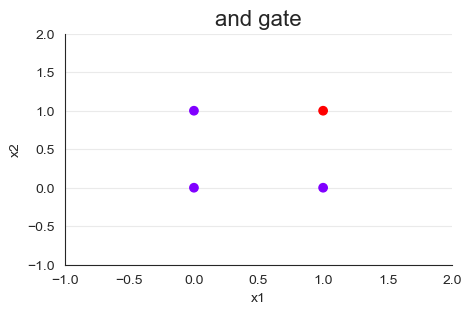

In [3]:
# 数据进行可视化
sns.set_style('white')  # 设置图像的风格
plt.figure(figsize=(5, 3))  # 设置画布大小
plt.scatter(X[:, 1], X[:, 2], c=and_gate, cmap='rainbow')  # 以X的值作为散点图的横纵坐标，颜色以and_gate对应的类别区分
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1, 2)  # 设置横纵坐标范围
plt.ylim(-1, 2)
plt.title('and gate', fontsize=16)  # 设置标题
plt.grid(alpha=0.4, axis='y')  # 设置背景网格
plt.gca().spines['top'].set_alpha(0)  # 上方和右侧的坐标轴被屏蔽
plt.gca().spines['right'].set_alpha(0)
plt.show()

可以看到，标签为0的数据分布在左下方，标签为1的数据分布在右上方，显然此时可以用一种更简单的方式对这些点分类，即画一条左上到右下的直线，直线的两边即为被划分出的2类，这也是机器学习中的常见操作。图示如下：
![sign_classification](../assets/sign_classification.png)
此时，在w和b都确定的情况下，给定一个$X_t$，就可以确定一个点，Xw>0时，在直线的一边，<0时在另一边，对应不同的标签。如下：
$$y=\left\{\begin{array}{ll}
1, & \text { if } \boldsymbol{X}_{\boldsymbol{t}} \boldsymbol{w}>0 \\
0, & \text { if } \boldsymbol{X}_{\boldsymbol{t}} \boldsymbol{w} \leq 0
\end{array}\right.$$
只有2个特征时，如下：
$$y=\left\{\begin{array}{ll}
1 & \text { if } w_{1} x_{1}+w_{2} x_{2}+b>0 \\
0 & \text { if } w_{1} x_{1}+w_{2} x_{2}+b \leq 0
\end{array}\right.$$
也就是：
$$y=\left\{\begin{array}{ll}
1 & \text { if } \boldsymbol{z}>0 \\
0 & \text { if } \boldsymbol{z} \leq 0
\end{array}\right.$$
显然，用线划分点的数学表达和之前的阶跃函数的表示方法一致。

In [4]:
# 实现
w_and = torch.tensor([-0.23, 0.15, 0.15])


# 用阶跃函数实现与门数据的二分类
def and_classification_with_sign(X, w):
    z_hat = X @ w
    y_hat = (z_hat >= 0).float()  # 使用直线来划分2个类别的点，即用阶跃函数划分与门数据
    return y_hat


# 调用
y_hat = and_classification_with_sign(X, w_and)
y_hat

tensor([0., 0., 0., 1.])

实际上，阶跃函数的本质也就是用直线划分点的过程，而这条具有分类功能的直线就是**决策边界**。在机器学习中，任意分类算法都可以绘制自己的决策边界，且依赖决策边界来进行分类。同时，既然决策边界的方程就是z的表达式，那在相同的数据X下（即在相同的数据空间中），决策边界具体在哪里就是由定义的w决定的。
现在以w1=0.15、w2=0.15、b=-0.23为例绘制决策边界。

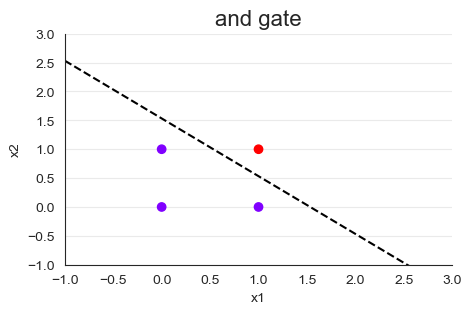

In [5]:
# 数据进行可视化
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 1], X[:, 2], c=and_gate, cmap='rainbow')
x1 = np.arange(-1, 3, 0.1)
plt.plot(x1, (0.23 - 0.15 * x1) / 0.15, color='k', linestyle='--')  # 绘制0.15 * x1 + 0.15 * x2 - 0.23 = 0
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('and gate', fontsize=16)
plt.grid(alpha=0.4, axis='y')
plt.gca().spines['top'].set_alpha(0)
plt.gca().spines['right'].set_alpha(0)
plt.show()

可以看到，这是一条能够将样本点完美分割的直线，设置的权重和截距绘制出的直线可以将与门数据中的两类点完美分开。所以对于任意的数据只需要找到适合的w和b就能够确认相应的决策边界，也就可以自由进行分类了。现在对或门、非与门和异或门进行尝试。

In [6]:
# 对或门数据进行分类
w_or = torch.tensor([-0.08, 0.15, 0.15])
or_gate = torch.tensor([0., 1, 1, 1])


def or_classification_with_sign(X, w):
    z_hat = X @ w
    y_hat = (z_hat > 0).float()
    return y_hat


y_hat = or_classification_with_sign(X, w_or)
y_hat, y_hat == or_gate

(tensor([0., 1., 1., 1.]), tensor([True, True, True, True]))

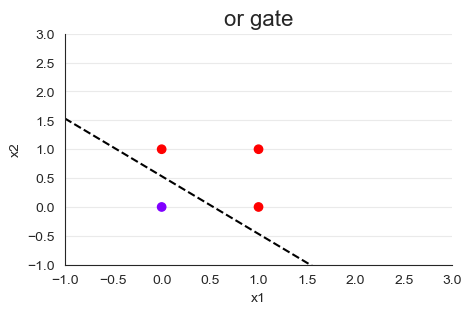

In [7]:
# 绘制或门的图像
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 1], X[:, 2], c=or_gate, cmap='rainbow')
x1 = np.arange(-1, 3, 0.1)
plt.plot(x1, (0.08 - 0.15 * x1) / 0.15, color='k', linestyle='--')  # 绘制0.15 * x1 + 0.15 * x2 - 0.08 = 0
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('or gate', fontsize=16)
plt.grid(alpha=0.4, axis='y')
plt.gca().spines['top'].set_alpha(0)
plt.gca().spines['right'].set_alpha(0)
plt.show()

In [8]:
# 对非与门数据进行分类
w_nand = torch.tensor([0.23, -0.15, -0.15])  # 和与门相反
nand_gate = torch.tensor([1., 1, 1, 0])


def nand_classification_with_sign(X, w):
    z_hat = X @ w
    y_hat = (z_hat >= 0).float()
    return y_hat


y_hat = nand_classification_with_sign(X, w_nand)
y_hat, y_hat == nand_gate

(tensor([1., 1., 1., 0.]), tensor([True, True, True, True]))

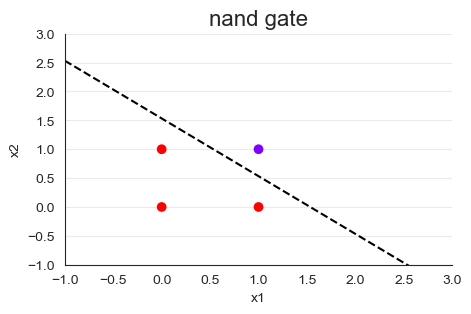

In [9]:
# 绘制非与门的图像
plt.figure(figsize=(5, 3))
plt.scatter(X[:, 1], X[:, 2], c=nand_gate, cmap='rainbow')
x1 = np.arange(-1, 3, 0.1)
plt.plot(x1, (0.23 - 0.15 * x1) / 0.15, color='k', linestyle='--')  # 绘制-0.15 * x1 - 0.15 * x2 + 0.23 = 0
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('nand gate', fontsize=16)
plt.grid(alpha=0.4, axis='y')
plt.gca().spines['top'].set_alpha(0)
plt.gca().spines['right'].set_alpha(0)
plt.show()

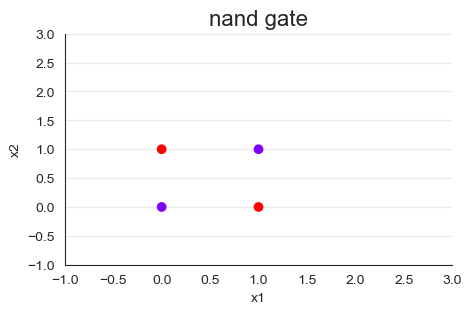

In [10]:
# 再尝试异或门的数据
xor_gate = torch.tensor([0., 1, 1, 0])

plt.figure(figsize=(5, 3))
plt.scatter(X[:, 1], X[:, 2], c=xor_gate, cmap='rainbow')
plt.xlabel('x1')
plt.ylabel('x2')
plt.xlim(-1, 3)
plt.ylim(-1, 3)
plt.title('nand gate', fontsize=16)
plt.grid(alpha=0.4, axis='y')
plt.gca().spines['top'].set_alpha(0)
plt.gca().spines['right'].set_alpha(0)
plt.show()

可以看到，此时找不到一条直线将两类点完美分开，并且现实中的大部分数据都是无法用直线完美分开的，即大部分变量之间的关系都无法用直线来拟合。对于疑惑数据，应该用一条曲线来划分，将单层神经网络变成多层即可将直线的决策边界变为曲线，图示如下：
![xor_multi_nn](../assets/xor_multi_nn.png)

图中的神经网络中，除了输入层和输出层，还多了一层中间层，数据依然是从左侧的输入层进入，特征会分别进入NAND和OR两个中间层的神经元，分别获得NAND函数的结果$sigma_{nand}$和OR函数的结果$sigma_{or}$，接着，$sigma_{nand}$和$sigma_{or}$会继续被输入下一层的神经元AND，经过AND函数的处理，获得最终结果y。下面进行实现。

In [11]:
# 输入层到中间层，调用已有的非与门和或门函数
sigma_nand = nand_classification_with_sign(X, w_nand)
sigma_or = or_classification_with_sign(X, w_or)
sigma_nand, sigma_or

(tensor([1., 1., 1., 0.]), tensor([0., 1., 1., 1.]))

In [12]:
# 构造中间层
x0 = torch.ones(sigma_nand.size(0))
X_mid = torch.stack([x0, sigma_nand, sigma_or], dim=1)
X_mid

tensor([[1., 1., 0.],
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 0., 1.]])

In [13]:
# 中间层到输出层
y_xor = and_classification_with_sign(X_mid, w_and)
y_xor, y_xor == xor_gate

(tensor([0., 1., 1., 0.]), tensor([True, True, True, True]))

可以看到，通过2层神经网络，结合使用与、或和非与，实现了对异或门数据的分类，即绘制出了曲线的决策边界，显然，多层的神经网络可以将直线的决策边界转变为曲线，以实现更复杂的分类,解决了单层神经网络无法处理的非线性问题，叠加了多层的神经网络也被称为**多层神经网络**。将上面的实现过程用函数表示。

In [14]:
def xor_classification_with_sign(X, w_and, w_or, w_nand):
    sigma_nand = nand_classification_with_sign(X, w_nand)
    sigma_or = or_classification_with_sign(X, w_or)
    x0 = torch.ones(sigma_nand.size(0))
    X_mid = torch.stack([x0, sigma_nand, sigma_or], dim=1)
    y_hat = and_classification_with_sign(X_mid, w_and)
    return y_hat


xor_classification_with_sign(X, w_and, w_or, w_nand)

tensor([0., 1., 1., 0.])

## 2.黑箱：深层神经网络的不可解释性
前面的多层神经网络相比单层神经网络多出了中间层，称为隐藏层，层数越多，神经网络的模型复杂度越高，一般也认为更深的神经网络可以解决更加复杂的问题，通常只会设置3~5个隐藏层。模型复杂度、数据量与模型表现的关系如下：
![model_depth_performance_data](../assets/model_depth_performance_data.png)

在一个神经网络中，所有的神经元都需要进行加和操作，区别在于加和之后的操作，例如Sigmoid、sign、ReLU和Tanh等，根据不同的需要进行选择，这类函数称为**激活函数**，在中间层用h(z)表示、输出层用g(z)表示。神经元和网络层编号如下：
![model_number](../assets/model_number.png)

权重、偏差、神经元上的取值编号规律如下：
![weight_bias_res_number](../assets/weight_bias_res_number.png)
以上面的疑惑神经网络为例，举例如下：
$$z_{1}^{1}=b_{\rightarrow 1}^{\rightarrow 1}+x_{1} w_{1 \rightarrow 1}^{0 \rightarrow 1}+x_{2} w_{2 \rightarrow 1}^{0 \rightarrow 1} \\
\begin{aligned}
\sigma_{1}^{1} & =h\left(z_{1}^{1}\right) =h\left(b_{\rightarrow 1}^{\rightarrow 1}+x_{1} w_{1 \rightarrow 1}^{0 \rightarrow 1}+x_{2} w_{2 \rightarrow 1}^{0 \rightarrow 1}\right)
\end{aligned}$$
可以看到，各种编号很容易让人感觉到头疼，虽然公式本身并不复杂，但涉及到神经网络不同的层以及每层上的神经元之间的数据流动，公式的编号会让人有所混淆。如果神经网络的层数继续增加，或每一层上神经元数量继续增加，神经网络的嵌套和计算就会变得更加复杂。
在实际中，真实数据可能有超过数百甚至数千个特征，所以真实神经网络的复杂度是非常高，计算非常缓慢的，所以当神经网络长成如下所示的模样，我们就无法理解中间过程了，很难知道究竟有多少个系数，如何相互作用产生了最终的预测结果，因此神经网络的过程是一个**黑箱**。每两层神经元之间，都会存在一个权重矩阵，权重将无法直接追踪到特征x上，这也是多层神经网络无法被有效解释的一个关键原因。

![multi_nn](../assets/multi_nn.png)
## 3.探索多层神经网络：层 vs 激活函数
之所以前面的2层神经网络可以拥有处理非线性问题的能力，不是因为在单层神经网络的基础上增加了一层，而是因为在神经元的加和之后增加了激活函数，具体来说是隐含层的激活函数。下面验证隐含层激活函数的作用。

In [15]:
# 修改或和非与的函数
def or_classification(X, w):
    z_hat = X @ w
    y_hat = z_hat
    return y_hat


def nand_classification(X, w):
    z_hat = X @ w
    y_hat = z_hat
    return y_hat


# 重新定义XOR的分类函数
def xor_classification(X, w_and, w_or, w_nand):
    sigma_nand = nand_classification(X, w_nand)
    sigma_or = or_classification(X, w_or)
    x0 = torch.ones(sigma_nand.size(0))
    X_mid = torch.stack([x0, sigma_nand, sigma_or], dim=1)
    y_hat = and_classification_with_sign(X_mid, w_and)
    return y_hat


xor_classification(X, w_and, w_or, w_nand), xor_gate

(tensor([0., 0., 0., 0.]), tensor([0., 1., 1., 0.]))

很显然，此时XOR函数的预测结果与标签不一致，经数学推导，可以发现，在没有隐含层激活函数时，输出层输出的结果为$x_{1} W_{1}+x_{2} W_{2}+B$，其中$W_{1}, W_{2}$和$B$都是常数，与第一次的输出结果$x_{1} w_{11}^{1}+x_{2} w_{12}^{1}+b_{1}^{1}$很类似，在层中流动的数据被做了仿射变换（affine
transformation），仿射变换后得到的依然是一个线性方程，而这样的方程不能解决非线性问题，因此“层”本身不是神经网络解决非线性问题的关键，层上的或函数才是，如果没有使用激活函数，或者激活函数为恒等函数，那增加再多的层也没有用。现在再尝试使用阶跃函数之外的其他函数作为激活函数。

In [16]:
# 修改或和非与的激活函数
def or_classification_with_sigmoid(X, w):
    z_hat = X @ w
    y_hat = z_hat.sigmoid()
    return y_hat


def nand_classification_with_sigmoid(X, w):
    z_hat = X @ w
    y_hat = z_hat.sigmoid()
    return y_hat


# 重新定义XOR的分类函数
def xor_classification_with_sigmoid(X, w_and, w_or, w_nand):
    sigma_nand = nand_classification_with_sigmoid(X, w_nand)
    sigma_or = or_classification_with_sigmoid(X, w_or)
    x0 = torch.ones(sigma_nand.size(0))
    X_mid = torch.stack([x0, sigma_nand, sigma_or], dim=1)
    y_hat = and_classification_with_sign(X_mid, w_and)
    return y_hat


xor_classification(X, w_and, w_or, w_nand), xor_gate

(tensor([0., 0., 0., 0.]), tensor([0., 1., 1., 0.]))

可以看到，激活函数换乘Sigmoid之后，还是不能达到分类的目的。因此，为了解决非线性问题，隐含层不仅要有激活函数，而且还需要选择合适的激活函数。否则神经网络的层数再多，也不一定有效。
## 4.激活函数
在人工神经网络的神经元上，根据一组输入定义该神经元的输出结果的函数，就是激活函数。激活函数一般都是非线性函数，它可以出现在神经网络中除了输入层以外的每层的每个神经元上。它是为了解决线性不可分的问题引出的，使数据更好的展现出我们想要的效果，转换的结果会作为下一层神经元的输入，最终决定了要发射给下一个神经元的内容，帮助网络学习数据中的复杂模式。

神经网络中可用的激活函数很多，可参考[https://en.wikipedia.org/wiki/Activation_function](https://en.wikipedia.org/wiki/Activation_function)。机器学习中常用的激活函数只有6种，包括恒等函数identity function、阶跃函数sign、Sigmoid函数、ReLU、Tanh、Softmax，其中：
- Softmax与恒等函数几乎不会出现在隐藏层上
- Sign、Tanh几乎不会出现在输出层上
- ReLU与Sigmoid是两种层都会出现

输出层的激活函数g(z)和隐含层的激活函数h(z)的主要区别如下：

**隐藏层和输出层上的激活函数作用是完全不一样的**：输出层的激活函数是为了让神经网络能够输出不同类型的标签而存在的，其中恒等函数用于回归、Sigmoid函数用于二分类、Softmax用于多分类，即输出层的激活函数仅仅与输出结果的表现形式有关，与神经网络的效果无关，因此它可以使用线性的恒等函数；但隐藏层的激活函数就不同，它的选择会直接影响神经网络的效果，而线性的函数会让神经网络的结构失效。

在同一个神经网络中，g(z)与h(z)可以是不同的，并且在大多数运行回归和多分类的神经网络时，它们也的确是不同的，每层上的h(z)可以是不同的，但是同一层上的激活函数必须一致。下面再对异或函数进行探索，隐含层选用阶跃函数、输出层选用Sigmoid函数。

In [17]:
# 修改与的激活函数
def and_classification_with_sigmoid(X, w, prob=0.5):
    z_hat = X @ w
    sigma = z_hat.sigmoid()  # 使用Sigmoid函数
    y_hat = (sigma >= prob).float()
    return y_hat


# 重新定义XOR的分类函数
def xor_classification_with_sigmoid_in_output(X, w_and, w_or, w_nand):
    sigma_nand = nand_classification_with_sign(X, w_nand)
    sigma_or = or_classification_with_sign(X, w_or)
    x0 = torch.ones(sigma_nand.size(0))
    X_mid = torch.stack([x0, sigma_nand, sigma_or], dim=1)
    y_hat = and_classification_with_sigmoid(X_mid, w_and)
    return y_hat


xor_classification_with_sigmoid_in_output(X, w_and, w_or, w_nand), xor_gate

(tensor([0., 1., 1., 0.]), tensor([0., 1., 1., 0.]))

可以看到，上面的尝试是有效的，因此只要h(z)是阶跃函数，XOR网络就一定能有效，这与g(z)是什么函数无关。一般情况下，激活函数就是指的隐含层的h(z)。
## 5.从0实现深度神经网络的正向传播
一个神经网络从左向右的过程是神经网络的正向传播，现在使用封装好的torch.nn模块来实现一个完整、多层的神经网络的正向传播。
假设有500条数据，20个特征，标签为3分类，现在要实现一个三层神经网络，这个神经网络的架构为：第一层有13个神经元，第二层有8个神经元，第三层是输出层，其中，第一层的激活函数是Relu、第二层是Sigmoid。

In [18]:
# 构造数据
X = torch.rand(500, 20)
y = torch.randint(3, size=(500, 1))
X.shape, y.shape

(torch.Size([500, 20]), torch.Size([500, 1]))

In [19]:
# 定义模型，继承自nn.Module
class Model(nn.Module):
    def __init__(self, in_features=10, out_features=2):
        '''
        初始化
        :param in_features: 输入神经网络的特征数目——输入层上的神经元个数
        :param out_features: 输出神经网络的数目——输出层上的神经元数目
        '''
        super().__init__()  # 继承父类Module，进行初始化
        self.linear1 = nn.Linear(in_features, 13, bias=True)
        self.linear2 = nn.Linear(13, 8)
        self.out = nn.Linear(8, out_features)

    def forward(self, x):
        '''
        神经网络前向传播
        :param x: 输入
        :return: 模型输出的结果
        '''
        z1 = self.linear1(x)
        sigma1 = torch.relu(z1)
        z2 = self.linear2(sigma1)
        sigma2 = z2.sigmoid()
        z3 = self.out(sigma2)
        sigma3 = F.softmax(z3, -1)
        return sigma3


# 实例化模型
input_dim = X.size(-1)
output_dim = y.unique().sum().int().item()
model = Model(input_dim, output_dim)
model  # 输出模型的结构

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
)

In [20]:
# 调用模型进行前向传播
output = model(X)
output.shape, output

(torch.Size([500, 3]),
 tensor([[0.3046, 0.3549, 0.3405],
         [0.3062, 0.3548, 0.3389],
         [0.3092, 0.3506, 0.3402],
         ...,
         [0.3074, 0.3528, 0.3398],
         [0.3039, 0.3514, 0.3446],
         [0.3035, 0.3541, 0.3424]], grad_fn=<SoftmaxBackward0>))

In [21]:
# 获取权重矩阵和偏置项
model.linear1.weight.shape, model.linear1.bias.shape  # w * x_t -> (13, 20) * (20, 500) -> (13, 500)

(torch.Size([13, 20]), torch.Size([13]))

In [22]:
model.linear2.weight.shape, model.linear2.bias.shape  # w * l1_out -> (8, 13) * (13, 500) -> (8, 500)

(torch.Size([8, 13]), torch.Size([8]))

In [23]:
model.out.weight.shape, model.out.bias.shape  # w * l2_out -> (3, 8) * (8, 500) -> (3, 500) -> (500, 3)

(torch.Size([3, 8]), torch.Size([3]))

前面在实现Model类时，继承自nn.Module，即继承了Module类中除`__init__()`方法中定义之外的所有属性和方法，只有在初始化时调用了`super().__init__()`，自定义的Model类才会继承Module类的`__init__()`方法、获得Module类初始化方法中定义的属性，这对模型的正常运行起到了至关重要的作用，如果不调用seper()函数，Model类将无法正常运行。Module类的初始化方法定义如下：
```python
def __init__(self) -> None:
    """
    Initializes internal Module state, shared by both nn.Module and ScriptModule.
    """
    torch._C._log_api_usage_once("python.nn_module")

    self.training = True
    self._parameters: Dict[str, Optional[Parameter]] = OrderedDict()
    self._buffers: Dict[str, Optional[Tensor]] = OrderedDict()
    self._non_persistent_buffers_set: Set[str] = set()
    self._backward_hooks: Dict[int, Callable] = OrderedDict()
    self._is_full_backward_hook = None
    self._forward_hooks: Dict[int, Callable] = OrderedDict()
    self._forward_pre_hooks: Dict[int, Callable] = OrderedDict()
    self._state_dict_hooks: Dict[int, Callable] = OrderedDict()
    self._load_state_dict_pre_hooks: Dict[int, Callable] = OrderedDict()
    self._modules: Dict[str, Optional['Module']] = OrderedDict()

forward: Callable[..., Any] = _forward_unimplemented
```
下面使用自定义Model类继承自Module类的常用属性和方法。

In [24]:
# 常用属性
model.training  # 指定模型是否用于训练

True

In [25]:
# 常用方法
model.cuda()  # 将模型转移到GPU上运行

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
)

In [26]:
model.cpu()  # 将模型转移到CPU上运行

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
)

In [27]:
# 对一个线性层初始化权重为0
def initialize_weights(m):
    print(m)
    if isinstance(m, nn.Linear):
        m.weight.data.fill_(0)
        print(m.weight)


model.apply(initialize_weights)  # 对模型中所有的层（__init__()方法中定义的Module类所有对象）执行同样的操作

Linear(in_features=20, out_features=13, bias=True)
Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.

Model(
  (linear1): Linear(in_features=20, out_features=13, bias=True)
  (linear2): Linear(in_features=13, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=3, bias=True)
)

In [28]:
# 获取模型的所有参数
for param in model.parameters():
    print(param)

Parameter containing:
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0